<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/full_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


# 1. Set up project in runtime
Copy the following cell and run it with your credentials to clone the repo, getting datasets as runtime files, and then delete your credentials.

In [3]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

fatal: destination path 'CPSC-440-Project' already exists and is not an empty directory.


'/content'

# 2. Preprocess data

Datasets:
- `largeset_multisize_v2`
  - Stored in Github repo, made from combination of other datasets. Dataset construction code in repo too
  - 16706 Images, in randomized order
  - Res 128x128 (grayscale images also available in 64x64, 32x32, 16x16)


In [4]:
''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [5]:
training_proportion = 0.8
validation_proportion = 0.0

def load_and_partition(path):
  arr = make_image_arr(path)
  cutoff = int(len(arr)*training_proportion)
  return arr[:cutoff], arr[cutoff:]

def make_tensor(arr):
  #Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
  #Inversion is np.moveaxis(arr, [2,2], [1,1])
  return torch.from_numpy(np.moveaxis(arr, [3,1], [1,2]))

color_train, color_test = load_and_partition('/content/CPSC-440-Project/datasets/largeset_multisize_v2/color')
gray_train, gray_test = load_and_partition('/content/CPSC-440-Project/datasets/largeset_multisize_v2/gray')

assert(len(color_train) == len(gray_train) and len(color_test) == len(gray_test))
n_train = len(color_train)
n_test = len(color_test)

color_train_tensors = make_tensor(color_train)
color_test_tensors = make_tensor(color_test)

gray_train_tensors = make_tensor(gray_train)
gray_test_tensors = make_tensor(gray_test)

100%|██████████| 16706/16706 [00:07<00:00, 2367.56it/s]


3904


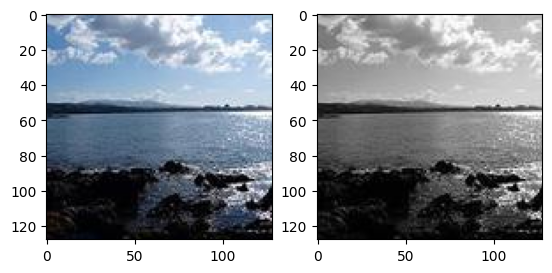

12867


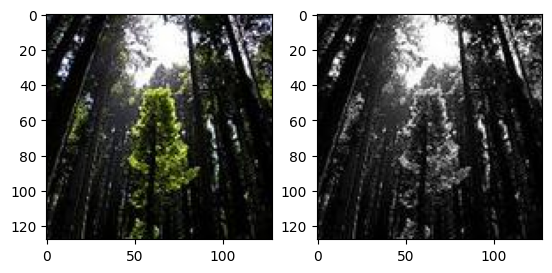

4208


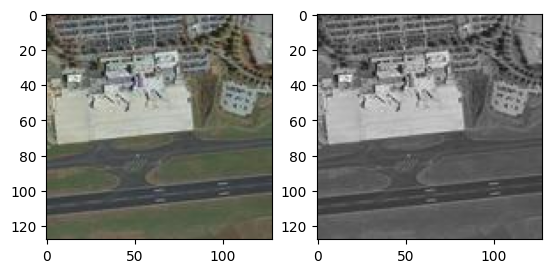

In [6]:
for i in np.random.randint(n_train,size=3):
  print(i)
  plt.subplot(1,2,1)
  plt.imshow(color_train[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_train[i])
  plt.show()

# 3. Model
Model generated below:

In [6]:
# prompt: pytorch colourization autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()

Train Model (SGD)

Further investigations: increasing architecture size, log loss for stability. STILL NEED TO TRAINING?TESTING PARTITION

Findings based on experiments:

L1 seemingly had more mode collapse? hard to compare losses.

Blurryness demonstrated to decrease with more iterations.

Weight decay has a meaningful impact on blurryness, probably something we don't want at the moment. Worth reconsidering in longer runs.

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
autoencoder.train()
autoencoder.to(device)

# Training loop
num_iterations = 10000
batch_size=16
for iteration in range(num_iterations):
    running_loss = 0.0
    batch_indexes = torch.randint(high=n_train, size=(batch_size,1))

    inputs = gray_train_tensors[batch_indexes].squeeze().to(device)
    targets = color_train_tensors[batch_indexes].squeeze().to(device)

    outputs = autoencoder(inputs)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    if (iteration % 1000 == 0): print('[%d] loss: %.3f' % (iteration, running_loss / batch_size))

print('Finished Training')

[0] loss: 0.003
Finished Training


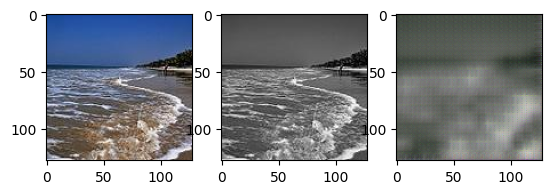

In [8]:
rand_index = random.randint(0, n_train)

image_bw = gray_train[rand_index]
image_c = color_train[rand_index]

# Colorize the image
t = (torch.from_numpy(np.moveaxis(image_bw, [2, 1], [0,2]))).to(device)
colorized_image = autoencoder(t)
colorized_image_format = np.moveaxis(colorized_image.cpu().detach().numpy(), [1,2], [0,1])

plt.subplot(1,3,1)
plt.imshow(image_c)
plt.subplot(1,3,2)
plt.imshow(image_bw)
plt.subplot(1,3,3)
plt.imshow(colorized_image_format)
plt.show()

# LEFT TO RIGHT: ORIGINAL, GRAYSCALE, COLORIZED

# Visualize model

Using [pytorchviz](https://github.com/szagoruyko/pytorchviz)!

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

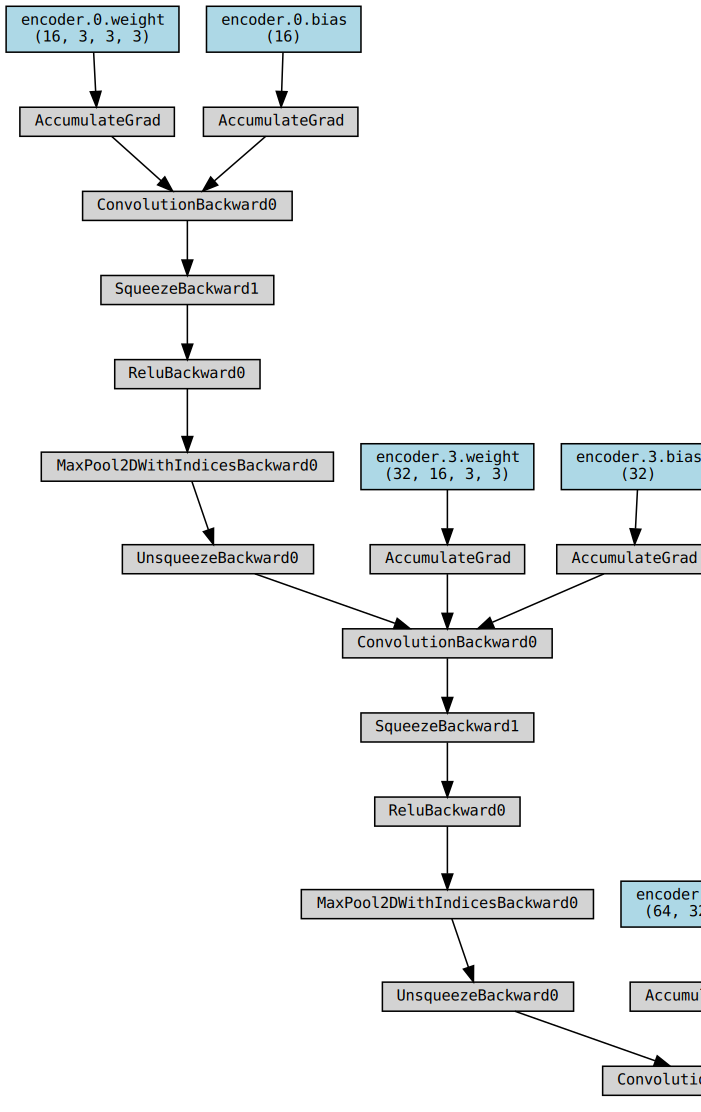

In [ ]:
from torchviz import make_dot
make_dot(colorized_image.mean(), params=dict(autoencoder.named_parameters()))

In [ ]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/v0/decoder_weights')

In [ ]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/v0/encoder_weights')

# Load model

In [ ]:
autoencoder.decoder = torch.load('/content/CPSC-440-Project/v0/decoder_weights')
autoencoder.encoder = torch.load('/content/CPSC-440-Project/v0/encoder_weights') # need some weights saved here!

# 4. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!